# Tweet-Clustering: HashTags with Tf-IDf 



In [22]:
import numpy as np
import pandas as pd
import imp
import lexrank
from matplotlib import pyplot as plt
from data_providers import DummyDataProvider, CachedSmallDataProvider
from clustering import DummyClustering, KMeansClustering, KMeansClusteringNew
from preprocessors import DummyPreprocessor, Cleaner
from vectorizers import DummyVectorizer, FastTextMeanVectorizer, FastTextTfIdfMeanVectorizer, TfIdfVectorizer, ElmoVectorizer
from sentiment import VaderSentimentAnalyser
from labeler import LexRankSummarizer
import utils
import random
from sklearn.preprocessing import normalize

# 1 Tweet-Data

In [23]:
# DATA
dataProvider1 = CachedSmallDataProvider("iphone")
tweets1 = dataProvider1.load_data()
print("number ", len(tweets1))
tweets1[:1]
# result - too many clusters still with 100 tweets

number  7190


['Create awesome custom faces for your #AppleWatch. Download AWC Faces #iphone #app https://t.co/ctiK1X9Kda']

In [24]:
# 1. DATA
dataProvider2 = CachedSmallDataProvider("alexa")
tweets2 = dataProvider2.load_data()
print("number ", len(tweets2))
tweets2[:1]

number  5469


['He’s so #beautiful love him! 🌸📚💕 #ariemanuel #mymollydoll #blog Thanks for following everyone! We are currently 8.3k share a following with @sassique where I’m a member and Ranked 37,818 in the #US on #Alexa // #blogger #blog #website @WMEBooks #thoughts 📖 https://t.co/m2RitarZYP']

In [25]:
# DATA
dataProvider3 = CachedSmallDataProvider("brexit")
tweets3 = dataProvider3.load_data()
print("number ", len(tweets3))
tweets3[:1]

number  71827


["Hey @tracey_crouch @TomTugendhat  Is this one of those #Brexit divedends for Kent we've been hearing so much about? https://t.co/hT85eKXHZz"]

In [26]:
# DATA
dataProvider4 = CachedSmallDataProvider("baseball")
tweets4 = dataProvider4.load_data()
print("number ", len(tweets4))
tweets4[:1]

number  3739


['Hey @MLB how about some justice for @PeteRose_14 he did nothing compared to the @astros #baseball']

In [27]:
# DATA
dataProvider5 = CachedSmallDataProvider("iran")
tweets5 = dataProvider5.load_data()
print("number ", len(tweets5))
tweets5[:1]

number  35167


['Can the #US bomb #Iran? Defense chief #Esper says no, then changes mind  https://t.co/avZn4sg8tt https://t.co/zLvik6fv87']

In [28]:
# DATA
dataProvider6 = CachedSmallDataProvider("trump")
tweets6 = dataProvider6.load_data()
print("number ", len(tweets6))
tweets6[:1]
# Result 22 clusters (sa) - highly polarized

number  34991


['@Farcethemusic And I say... 🎶 “let’s Build A Wall around the White House &amp; then let’s lock him up”https://t.co/UAYJTZQCff #CountryMusic #Country #Nashville #POTUS #Trump #BananaRepublic #2020Election #AbuseOfPower #Americana #25thAmendmentNow #AltFolk #NewMusicAlert #NewMusic #Ukrainegate']

In [29]:
# 1. DATA
#merge tweets
tweets = tweets1
#tweets = tweets3
#random.shuffle(tweets)

In [30]:
# 1. DATA
# reduce number of tweets 
tweets = tweets[:1000]

In [31]:
# create dataframe
dfTweet = pd.DataFrame({"tweets":tweets})
dfTweet["clean_tweets"] = ""
dfTweet["hashTags"] = ""
dfTweet["at"] = ""

# 2. Cleaning and Hash-Tag Extraction

In [32]:
cleaner = Cleaner()

In [33]:
# A Hash-Tag-Pipe
# extract hashtags and create_set of hashtags for each tweet
hashTagSet = set()
atSet = set()
for index, row in dfTweet.iterrows():
    hashTagTempSet = []
    atTempSet = []
    words = row['tweets'].split(' ')
    for word in words:
        if word[:1] == "#" and len(word)>1:
            word = cleaner.cleanTextButLeaveTagSymbols(word).lower()
            hashTagTempSet.append(word)
            hashTagSet.add(word)
        if word[:1] == "@" and len(word)>1:
            word = cleaner.cleanTextButLeaveTagSymbols(word).lower()
            atTempSet.append(word)
            atSet.add(word)
    row['hashTags'] = hashTagTempSet
    row['at'] = atTempSet

In [34]:
# A. Hash-Tag-Pipe
# show hashtags

print(len(hashTagSet))
pd.Series(list(hashTagSet)).describe().T

2126


count                 2126
unique                2126
top       #specifications,
freq                     1
dtype: object

In [35]:
# B. Tweet-Pipe
# does various clean up-jobs
vocabDicFreq, vocabDic,clean_tweets = cleaner.clean_tweets(tweets, 2 )
dfTweet['clean_tweets'] = clean_tweets
print(clean_tweets[0])

create awesome faces applewatch download faces iphone app


# 3: Vectorization of Hash Tags

In [36]:
# A: build sparse tf-idf vectors of HASH TAGS
# attention this cleans the hashtags - useful for embedding...
hashTagsList = dfTweet['hashTags'].values.tolist()
#print(hashTagsList)
newList = []
for index in range(len(hashTagsList)):
    string = ""
    for hashTag in hashTagsList[index]:
        string += hashTag + " "
    newList.append(string)
preVectorizer = TfIdfVectorizer()
X, docSparseTfIdf, vocabDic = preVectorizer.vectorizeFast(newList)
print(len(docSparseTfIdf))

1000


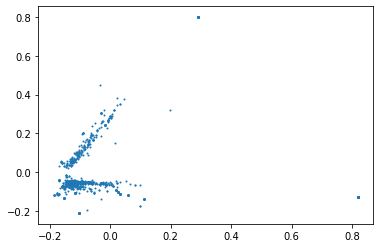

In [37]:
# A. Show tf-Idf Vecotrs of HashTags
utils.scatter2d(X.toarray())

# 3. Clustering of Hash Tags

In [38]:
# 2.A. Determina optimal number of cluster - other method - with hashtags - only 2/3s due to duplicates can be checked
# DIFFERENT SETTINGS FOR optimal number of clusters i.e. init="k-means++", max_iter etc. pp.
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score, davies_bouldin_score
clusterer = KMeansClusteringNew()
min = 2
max = 66
SA = {}
CH = {}
DB = {}
vecs = X.toarray()
for index in range(min, max):
    cluster_labels = clusterer.cluster(vecs, index)
    SA[index] = silhouette_score(vecs, cluster_labels)
    CH[index] = calinski_harabasz_score(vecs, cluster_labels)
    DB[index] = davies_bouldin_score(vecs, cluster_labels)

# find minimum and Maximum
sortedSA = {k: v for k, v in sorted(SA.items(), key=lambda item: item[1], reverse=True)}
bestSAIndex = next(iter(sortedSA))
print(" SA best ", bestSAIndex, " : ", SA[bestSAIndex] )
sortedSA = {k: v for k, v in sorted(SA.items(), key=lambda item: item[1], reverse=False)}
worstSAIndex = next(iter(sortedSA))
print(" SA worst ", worstSAIndex, " : ", SA[worstSAIndex] )
#print("SA", pd.Series(list(SA.values())).describe().T)
# ++++++++++++++++++++++++++++++++++++++
sortedCH = {k: v for k, v in sorted(CH.items(), key=lambda item: item[1], reverse=True)}
bestCHIndex = next(iter(sortedCH))
print(" CH best ", bestCHIndex, " : ", CH[bestCHIndex] )
sortedCH = {k: v for k, v in sorted(CH.items(), key=lambda item: item[1], reverse=False)}
worstCHIndex = next(iter(sortedCH))
print(" CH worst ", worstCHIndex, " : ", CH[worstCHIndex] )
#print("CH", pd.Series(list(CH.values())).describe().T)
# +++++++++++++++++++++++++++++++++++++++++
sortedDB = {k: v for k, v in sorted(DB.items(), key=lambda item: item[1], reverse=False)}
bestDBIndex = next(iter(sortedDB))
print(" DB best ", bestDBIndex, " : ", DB[bestDBIndex] )
sortedDB = {k: v for k, v in sorted(DB.items(), key=lambda item: item[1], reverse=True)}
worstDBIndex = next(iter(sortedDB))
print(" DB worst ", worstDBIndex, " : ", DB[worstDBIndex] )
#print("DB", pd.Series(list(DB.values())).describe().T)

# ++++++++++++++ create mixed ranking
print("joint ranking")
from sklearn.preprocessing import MinMaxScaler
Ranking = {}
for index in range(min, max):
    Ranking[index] = SA[index]/SA[bestSAIndex] + CH[index]/CH[bestCHIndex] - DB[index]/DB[worstDBIndex]
    #print(Ranking[index])
sortedRanking = {k: v for k, v in sorted(Ranking.items(), key=lambda item: item[1], reverse=True)}
count = 10
for key, value in sortedRanking.items():
    count -=1
    print(key, " ", value, " Silhouette ", SA[key])
    if count == 0:
        break

 SA best  65  :  0.2686692196717955
 SA worst  2  :  0.023174306492558753
 CH best  7  :  25.04290734581417
 CH worst  2  :  6.188150327170381
 DB best  16  :  1.0651124518437294
 DB worst  3  :  5.159208924202672
joint ranking
11   1.2688132814586761  Silhouette  0.13459992211829877
24   1.20639463287386  Silhouette  0.21214669035195374
65   1.1651701818125755  Silhouette  0.2686692196717955
20   1.1591913118954582  Silhouette  0.18843480151303577
36   1.0903976933313446  Silhouette  0.2186590329067403
7   1.0845854040597285  Silhouette  0.08573307487449691
59   1.0827266343960145  Silhouette  0.25297041464810405
33   1.0823327728292655  Silhouette  0.21802693737476062
26   1.0607531362625513  Silhouette  0.2012691206861491
43   1.0553464610300551  Silhouette  0.26075462626561385


In [39]:
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets import make_blobs
bandwidth = estimate_bandwidth(vecs)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(vecs)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 1


In [41]:
# 2.A. set clusters manually
cluster_optimal_number2 = 60

In [42]:
# 2.A. Cluster

clusterer = KMeansClusteringNew()
cluster_assignments2 = clusterer.cluster(vecs, cluster_optimal_number2)

In [43]:
print( "cluster assignments: ")
clusterCount = pd.Series(cluster_assignments).value_counts()
print(clusterCount.describe().T)
print(clusterCount)

cluster assignments: 


NameError: name 'cluster_assignments' is not defined

For n_clusters = 60 The average silhouette_score is : 0.31979943807060224


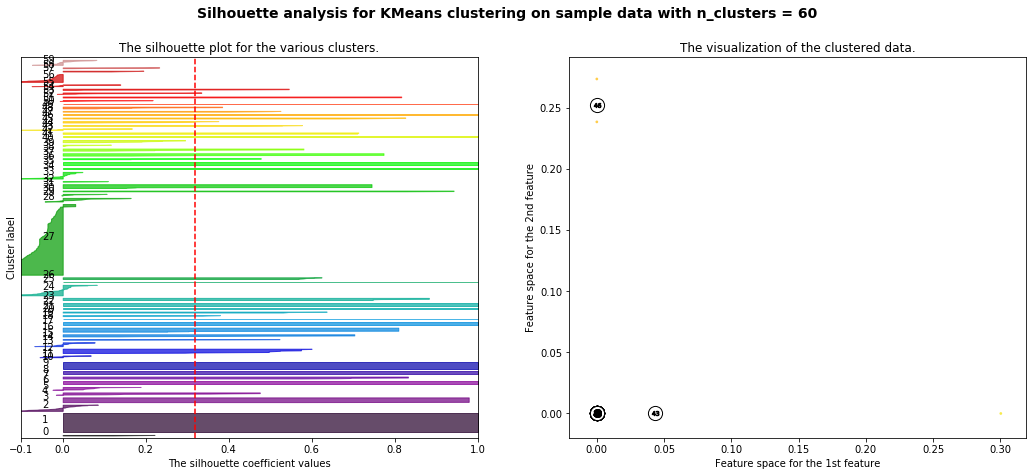

In [44]:
# analyser TFIDF
min = cluster_optimal_number2
max = cluster_optimal_number2 + 1
clusterer.silhouette_analyser(vecs, min, max)




# Step 4 b: Labeling Clusters

In [45]:
# 3. Cluster Labeling

def topWords(df, clusterNum):
#find 10 most frequent words for each cluster
# vars
    clusterNumber = clusterNum
    clusterStr = ["" for i in range(clusterNumber)]
    topTex = [[] for i in range(clusterNumber)]
    clusterSent =[0 for i in range(clusterNumber)]
    for index in range(len(clean_tweets)):
        cluster = df.at[index, 'cluster']
        string = clusterStr[cluster]
        string += str(df.at[index, 'tweets'])
        string += " "
        clusterStr[cluster] = string
    # sort 
    # clean and count words in 
    for index in range(clusterNumber):
        liste1 = ["", clusterStr[index]]
        vocabDicFreq2, vocabDic2, clean_tweets2 = cleaner.clean_tweets(liste1, 0)
        sortedDicFreq = {k: v for k, v in sorted(vocabDicFreq2.items(), key=lambda item: item[1], reverse=True)}
        liste = list(sortedDicFreq.keys())
        topTex[index] = liste[:10]
    for index in range(clusterNumber):
        print("Cluster ", index, " top 10: ", topTex[index])

In [46]:
# 3. Cluster Labeling
# analyse compare

dictClusterTweets = {'cluster':cluster_assignments2, 'tweets':clean_tweets}
df = pd.DataFrame(dictClusterTweets)
df['Counts'] = df.groupby(['cluster']).transform('count')
pd.options.display.max_colwidth = 4000
pd.set_option('display.max_rows', df.shape[0]+1)

topWords(df, cluster_optimal_number2)


Cluster  0  top 10:  ['iphone', 'apple', 'new', 'check', 'camera', 'us', 'free', 'iphones', '8plus', 'jaiiryda']
Cluster  1  top 10:  ['android', 'iphone', 'tech', 'technology', 'science', 'bigdata', 'awesome', 'ios', 'mobile', 'video']
Cluster  2  top 10:  ['iphone', 'art', 'dynamic', 'portrait', 'user', 'new', '', 'giant', 'small', 'found']
Cluster  3  top 10:  ['', 'purchase', 'email', 'apple', 'got', 'id', 'without', 'watch', 'iphone']
Cluster  4  top 10:  ['dynamic', 'portrait', 'iphone', 'user', 'digitalart', 'new', '', 'brand', 'remarkable', 'forgotten']
Cluster  5  top 10:  ['apple', '', 'latest', 'model', 'iphone', 'around', 'go', 'samsung']
Cluster  6  top 10:  ['iphone', 'mac', 'digital', 'forensics', 'firm', 'cellebrite_ufed', 'expanding', 'acquisition', 'blackbagtech', 'adding']
Cluster  7  top 10:  ['deals', 'deal', 'iphone', 'freebies', 'moneysaver', 'greatdeal', 'steals', 'discount', 'sale', 'bargain']
Cluster  8  top 10:  ['listen', 'reggaeton', 'app', 'needed', 'visit

# Step 5 Sentiment

In [47]:
# 2.B. Sentiment Analyser Vader
def sentiment(df):
    sentiment_analyser = VaderSentimentAnalyser()
    sentiments = sentiment_analyser.get_sentiment(clean_tweets)
    df['sentiment'] = sentiments
    df.sort_values(by=['cluster'], inplace=True, ascending=True)
    print(df.groupby(['cluster'])['sentiment'].mean())
    print(df.nsmallest(20, 'sentiment'))
    print(df.nlargest(20, 'sentiment'))

In [48]:
# 3. Topicc-Groups with Sentiments
sentiment(df)

cluster
0     0.573131
1     0.861459
2     0.672914
3     0.500000
4     0.704690
5     0.500000
6     0.562914
7     0.625000
8     0.670000
9     0.385867
10    0.771150
11    0.680600
12    0.607851
13    0.500000
14    0.651761
15    0.671671
17    0.461400
18    0.622350
19    0.461400
20    0.550575
21    0.527814
23    0.500000
24    0.670000
26    0.500000
27    0.559737
28    0.569061
29    0.500000
30    0.594903
31    0.647917
32    0.500000
33    0.500000
34    0.500000
36    0.500000
37    0.845400
38    0.755300
39    0.500000
41    0.700950
45    0.885850
46    0.500000
47    0.720200
48    0.676904
50    0.605911
51    0.639867
52    0.967450
53    0.364425
55    0.792950
56    0.585964
57    0.500000
58    0.755300
59    0.549390
Name: sentiment, dtype: float64
     cluster  \
400        0   
237        0   
952       12   
260       12   
399       12   
719       12   
968       12   
750        0   
151       12   
940       21   
3         12   
672       12   
45

In [49]:
df["sentiment"].describe().T

count    1000.000000
mean        0.607542
std         0.168870
min         0.058300
25%         0.500000
50%         0.500000
75%         0.746950
max         0.980350
Name: sentiment, dtype: float64